# Final

In [41]:
import secrets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics.pairwise import euclidean_distances
sns.set_context("paper")

In [6]:
data_path = Path().resolve().parent / "data"

In [7]:
# Random seed for reproducibility
# secrets.randbits(128) # 208905213533139122735706682150229709525
rng = np.random.default_rng(208905213533139122735706682150229709525)
indices_train = rng.choice(5000, 500, replace=False)
indices_test = rng.choice(800, 500, replace=False)
flag_full_dataset = False  # If it is True it will use full train and test datasets

In [8]:
train_list = []  # Auxiliary list of train datasets
for f in data_path.glob("train*.txt"):
    # Sample or full dataset
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_train, :]
    target = raw_data[:, [0]]  # Target values, i.e. digit
    features = raw_data[:, 1:] / 255
    train_list.append(np.hstack((target, features)))  # Add to the temp list
train_data = np.vstack(train_list)  # Concatenate train datasets
train_data.shape

(5000, 785)

In [9]:
# Similar to train dataset
test_list = []
for f in data_path.glob("test*.txt"):
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_test, :]
    target = raw_data[:, [0]]
    features = raw_data[:, 1:] / 255
    test_list.append(np.hstack((target, features)))
test_data = np.vstack(test_list)
test_data.shape

(5000, 785)

In [10]:
# Split datasets into features matrices and target vectors
X_train = train_data[:, 1:]
y_train = train_data[:, 0].astype(int)
X_test = test_data[:, 1:]
y_test = test_data[:, 0].astype(int)

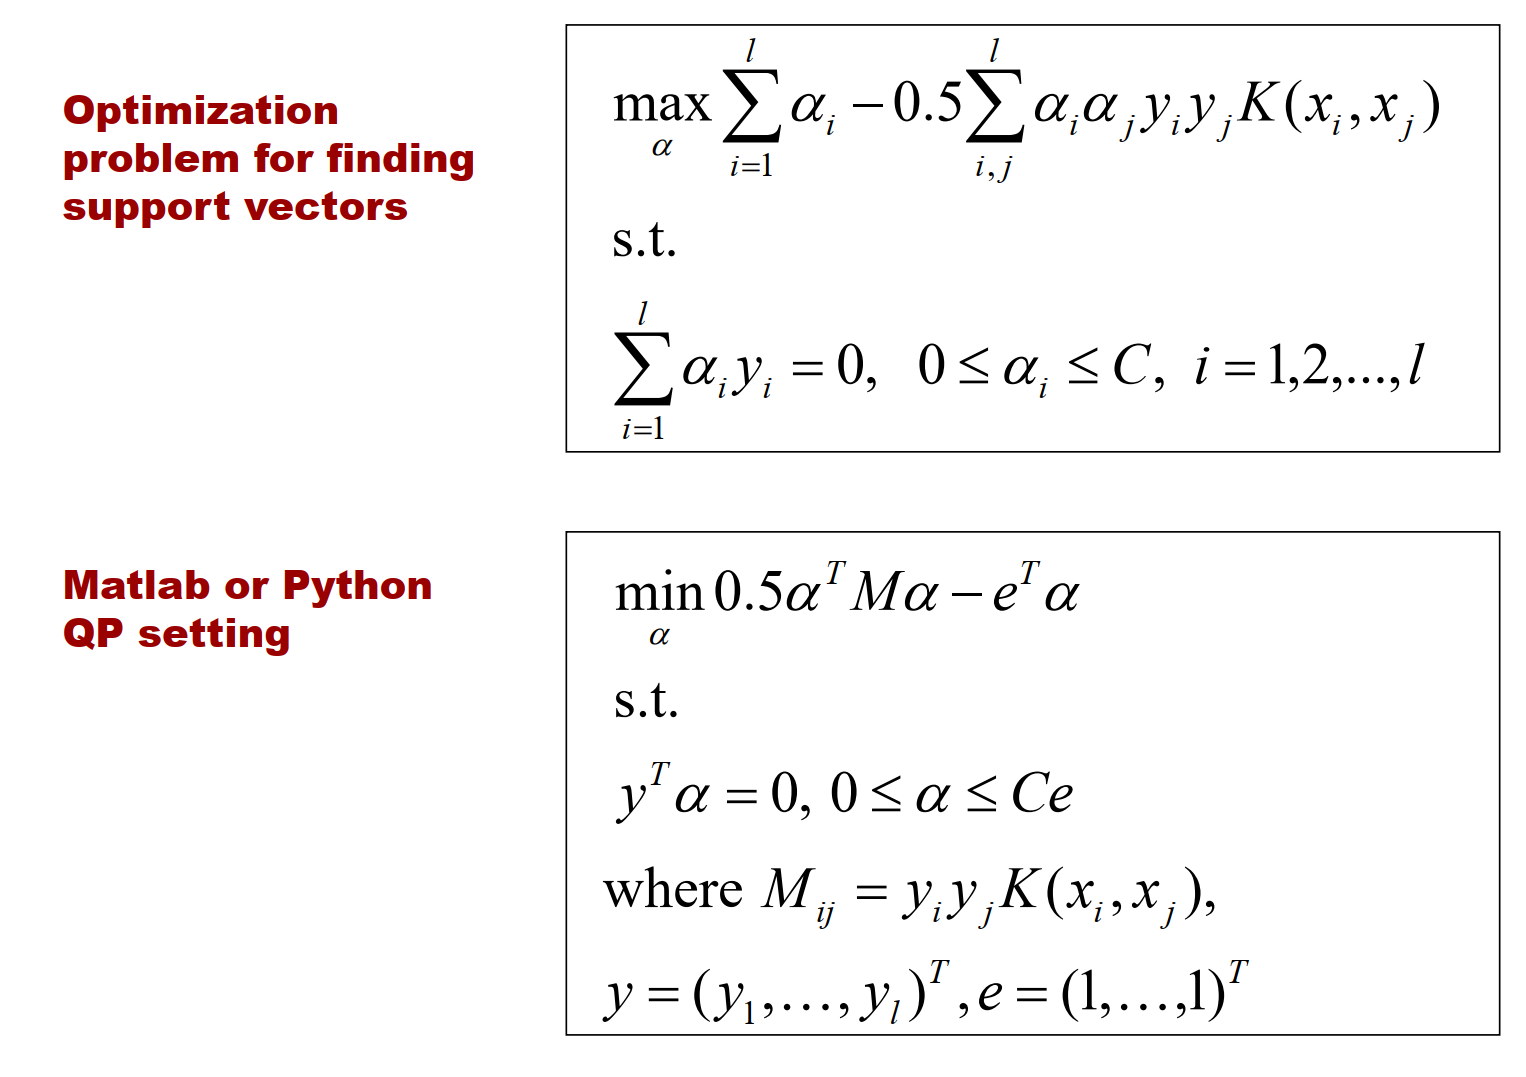

## 1.

In [32]:
def get_data(labels, n_train_label, n_test_label, rng):
    train_list = []  # Auxiliary list of train datasets
    for f_train in data_path.glob("train*.txt"):
        if f_train.stem.removeprefix("train") not in map(str, labels):
            continue
        raw_train = np.loadtxt(f_train)
        if n_train_label is not None:
            indices_train = rng.choice(raw_train.shape[0], n_train_label, replace=False)
            raw_train = raw_train[indices_train, :]
        target_train = raw_train[:, [0]]  # Target values, i.e. digit
        features_train = raw_train[:, 1:] / 255
        train_list.append(np.hstack((target_train, features_train)))
    train_data = np.vstack(train_list)  # Concatenate train datasets

    test_list = []
    for f_test in data_path.glob("test*.txt"):
        if f_test.stem.removeprefix("test") not in map(str, labels):
            continue
        raw_test = np.loadtxt(f_test)
        if n_test_label is not None:
            indices_test = rng.choice(raw_test.shape[0], n_test_label, replace=False)
            raw_test = raw_test[indices_test, :]
        target_test = raw_test[:, [0]]
        features_test = raw_test[:, 1:] / 255
        test_list.append(np.hstack((target_test, features_test)))
    test_data = np.vstack(test_list)
    X_train = train_data[:, 1:]
    y_train = train_data[:, 0].astype(int)
    X_test = test_data[:, 1:]
    y_test = test_data[:, 0].astype(int)
    return X_train, y_train, X_test, y_test

In [ ]:
def radial_basis(X, gamma):
    K = np.exp(-gamma * euclidean_distances(X, squared=True))
    return K

In [68]:
labels = np.array([3, 6])
n_train_label = 500
n_test_label = 500
gamma = 0.03
X_train, y_train, X_test, y_test = get_data(labels, n_train_label, n_test_label, rng)

In [59]:
# y_i \in {-1, 1}
min_label = np.min(labels)
y_train_bin = np.where(y_train == min_label, -1, 1)
y_test_bin = np.where(y_test == min_label, -1, 1)

In [70]:
M = np.outer(y_train_bin, y_train_bin) * radial_basis(X_train, gamma)